In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import skimage as si
from scipy import ndimage

In [ ]:
print(os.getcwd()+"\Data\TrayImages\Keria_03_1904.jpg")

In [99]:
img1 = cv2.imread(os.getcwd()+"\Data\TrayImages\Keria_03_1904.jpg")
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_OTSU)
rect = ndimage.binary_fill_holes(~thresh)
rect = si.morphology.binary_opening(rect,np.ones((20,20))).astype(int)

In [80]:
print(ret)
type(thresh)
print(np.shape(thresh))

130.0
(4000, 3000)


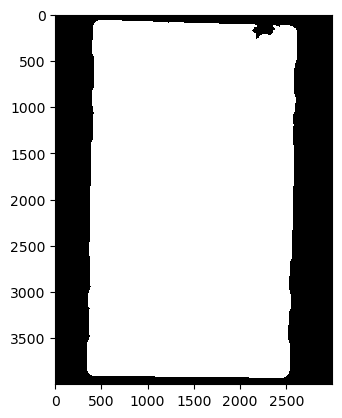

In [101]:
plt.imshow(rect, cmap='gray')
plt.show()

In [100]:
print(rect)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [103]:
image, contours, hierarchy = cv2.findContours(rect, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

error: OpenCV(4.0.1) C:\ci\opencv-suite_1573470242804\work\modules\imgproc\src\contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'
